In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Class imports
%run DataSplitter.ipynb
%run Kernel.ipynb
%run Model.ipynb    
%run Trainer.ipynb
import numpy as np

np.random.seed(6)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

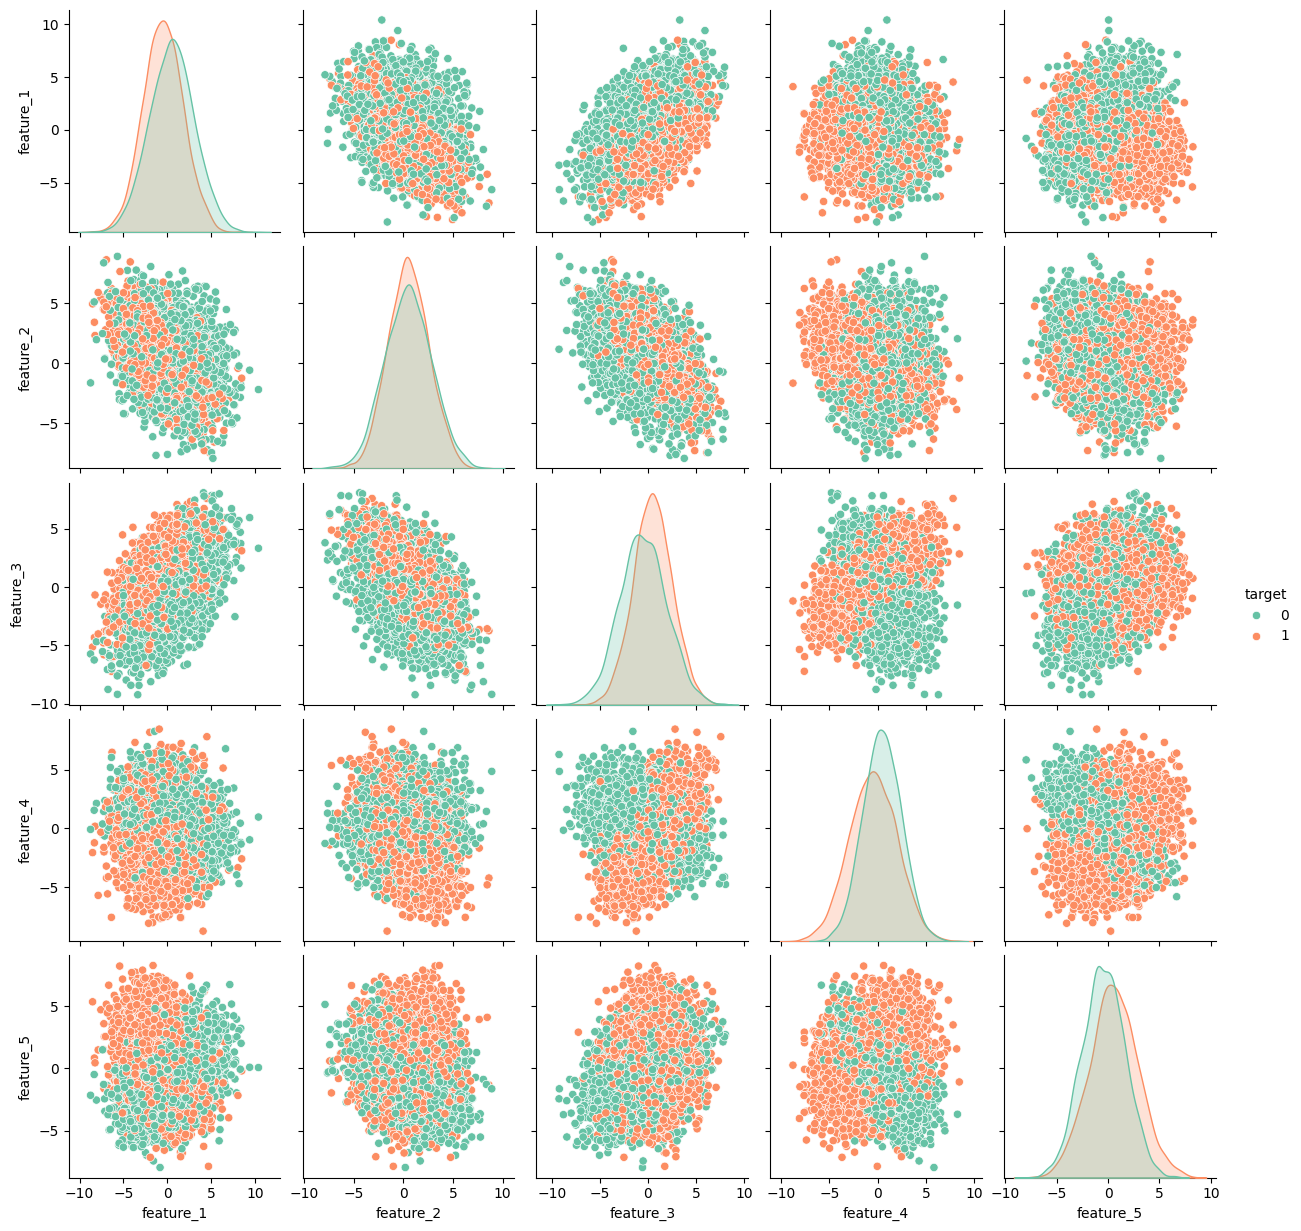

In [2]:
# Generating data
no_features = 16
X, y = make_classification(n_samples=10000, n_features=no_features, n_informative=16, 
                           n_classes=2, n_redundant=0, n_clusters_per_class=1, class_sep=0.5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

temp = pd.DataFrame(X[:,:5], columns=[f'feature_{i}' for i in range(1, 6)])
temp_data = pd.concat([temp, pd.Series(y, name='target')], axis=1)

sns.pairplot(data=temp_data, hue='target', palette='Set2')

In [3]:
# Linear SVC
model=SVC(C=0.1, kernel='poly', degree=2, decision_function_shape='ovr') # all default apart from C=1 . Hinge loss
model.fit(X_train, y_train) 
pred=model.predict(X_test)

print('Linear SVM:')
print(confusion_matrix(y_test,pred))
print(classification_report(y_test, pred))
print('\n')
# RBF and Poly have very similar results

# SGDClassifier
model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, l1_ratio=0.15, max_iter=1000, 
              tol=0.001, shuffle=True, n_jobs=None, random_state=42, learning_rate='optimal', eta0=0.0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print('SGD Classifier:')
print(confusion_matrix(y_test,pred))
print(classification_report(y_test, pred))

Linear SVM:
[[956  47]
 [ 12 985]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1003
           1       0.95      0.99      0.97       997

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



SGD Classifier:
[[879 124]
 [131 866]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1003
           1       0.87      0.87      0.87       997

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



In [4]:
positive_indices = np.where(y_train == 1)[0]
negative_indices = np.where(y_train == 0)[0]
X_train_split = {-1: X_train[negative_indices], 1: X_train[positive_indices]}

A_pos = X_train_split[1]
A_neg = X_train_split[-1]

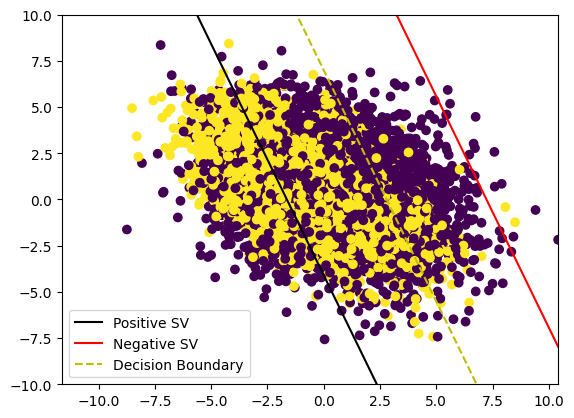

In [7]:
# 2-class classification
# For 3-class, A_pos is prediction class, A_neg is all other classes/one other (OvR or OvO)
# A_pos, A_neg = must be numpy mxn array
# w0, b0 = initial point in Newton method. w0 is nx1 array, b0 is float value
# w0 must be an array of size mx2 or more - ie. data points x >=2 feature

# Try the model
%run Model.ipynb  

C = 0.1  
w0 = np.zeros((X.shape[1], 1)) # initial estimates - same dim as no. features
b = 1
ssvm = SSVM(A_pos, A_neg, C, w0, b, delta=-1, beta=1)
# pickle the model
# with open('model.pkl', 'wb') as f:
#     pickle.dump(ssvm, f)
    
results = ssvm.train()
w = results["w"]
b = results["b"]
print(f'w:{w})')
print(f'b:{b})')

colors = {1:'r',-1:'b'}
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
X_train = pd.DataFrame(X_train)
plt.scatter(X_train.iloc[:,0],X_train.iloc[:,1],marker='o',c=y_train)

def hyperplane_value(x,w,b,v):
    return (-w[0]*x-b+v) / w[1]

max_feature_value, min_feature_value = np.max(X), np.min(X)
datarange = (min_feature_value*0.9, max_feature_value*1.)
hyp_x_min = datarange[0]
hyp_x_max = datarange[1]

# (w.x+b) = 1
# positive support vector hyperplane
psv1 = hyperplane_value(hyp_x_min, w, b, 1)
psv2 = hyperplane_value(hyp_x_max, w, b, 1)
ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k', label='Positive SV')

# (w.x+b) = -1
# negative support vector hyperplane
nsv1 = hyperplane_value(hyp_x_min, w, b, -1)
nsv2 = hyperplane_value(hyp_x_max, w, b, -1)
ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'r', label='Negative SV')

# (w.x+b) = 0
# positive support vector hyperplane
db1 = hyperplane_value(hyp_x_min, w, b, 0)
db2 = hyperplane_value(hyp_x_max, w, b, 0)
ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--', label='Decision Boundary')

plt.axis([min_feature_value,max_feature_value,-10,10])
plt.legend()

## Smoothed SVM:
- Start with any $(w_{0}, \gamma_{0})$. If gradient of $\nabla \phi_{\alpha}(w^i, \gamma^i) = 0$, stop. Else, $(w^{i+1}, \gamma^{i+1})$
- Newton direction: Determine direction by setting linearization $\nabla \phi_{\alpha}(w, \gamma) = 0$ around $(w^{i}, \gamma^{i})$ which gives n+1 linear equations in n+1 variables:
$
\begin{equation}
p_{k} = - \nabla^2 \phi_{\alpha}(w^{i}, \gamma^{i})^{-1} \nabla \phi_{\alpha}(w^{i}, \gamma^{i})' 
\end{equation}
$
- Armijo stepsize: Choose stepsize $\lambda$ such that:
$
\begin{equation}
(w^{i+1}, \gamma^{i+1})= (w^{i}, \gamma^{i}) + \lambda_{i} p_{k}
\end{equation}
$
where $\lambda$ = max{1,0.5,0.25,...} such that;
$
\begin{equation}
\phi_{\alpha}((w^{i}, \gamma^{i}) +\lambda_{i} p_{k}) \leq  \phi_{\alpha}(w^{i}, \gamma^{i}) + \delta \lambda_{i} \nabla \phi_{\alpha}(w^{i}, \gamma^{i})^{T} p_{k}
\end{equation}
$
where $\delta$ [0, 0.5]

$ p_{k} = d^{i}$ = step direction, $ \lambda $ = step size, $\delta$ = [0,1]


we used the limit values of the sigmoid function and the p function as the smoothing parameter $\alpha$ goes to infinity, that is the unit step function with value 12 at zero and the plus function (·)+ respectively, when we computed the Hessian matrix and the gradient in newton direction step. This gave slightly faster computational times but made no difference in the computational results from those obtained with $\alpha$ = 5.

In [5]:
data = np.hstack([X, y.reshape(-1,1)])

In [347]:
data = np.hstack([X, y.reshape(-1,1)])

%run Model.ipynb    
%run Trainer.ipynb

# no_features = position of y column
trainer = Trainer(data, no_features, r=1, v=2, delta=-0.8, beta=0.4) # 2 folds, all data
trainer.train()
# save(fname="model") # can only be saved for 1 fold runs

{'TAcc': 0.9676, 'VAcc': 0.9648, 'time': 3943.954481124878}

## Reduced SVM:
- Choose 1-10% of the data
- Solve: 
$
\begin{equation}
\min_{(\tilde{u},\gamma) \in \mathbb{R}^{\tilde{m}+1}} \frac{\nu}{2} \|p(e - D(K(A, \tilde{A}')\tilde{D}\tilde{u} - e\gamma), \alpha)\|_2^2 + \frac{1}{2}(\tilde{u}^T\tilde{u} + \gamma^2), 
\end{equation}
$
$
\begin{equation}
 p(x,\alpha) = x + 1/\alpha \log(1+\epsilon^{\alpha x}), \alpha > 0 
\end{equation}
$
- The separating surface is:
$
\begin{equation}
 K(x', \tilde{A}')\tilde{D}\tilde{u} = \gamma
\end{equation}
$
- A new point is classified as 1 or -1 based on step function:
$
\begin{equation}
 (K(x', \tilde{A}')\tilde{D}\tilde{u} - \gamma)*
\end{equation}
$
being 1 or 0 
- Use 10-fold CV to confirm

In [19]:
%run Trainer.ipynb

times = []
best_delta = 0
best_beta = 0
best_val_acc = 0
val_range = [-.8, -.6, -.4, -.2, .2, .4, .6, .8]
for i, delta in enumerate(val_range):
    print(f'Delta {i+1} of {len(val_range)}')
    for beta in val_range:
        trainer = Trainer(data, no_features, r=0.1, v=3, delta=delta, beta=beta) # 3-folds, 10% of data
        x = trainer.train()
        times.append(x['time'])
        
        if x['VAcc'] > best_val_acc:
            best_val_acc = x['VAcc']
            best_delta = delta
            best_beta = beta

print(f'Delta: {best_delta}, Beta: {best_beta}, Val_accuracy: {best_val_acc}')

Delta 1 of 8
Delta 2 of 8
Delta 3 of 8
Delta 4 of 8
Delta 5 of 8
Delta 6 of 8
Delta 7 of 8
Delta 8 of 8
Delta: -0.8, Beta: 0.4, Val_accuracy: 0.9579999160837485


In [20]:
print(f'Mean time for 3-fold model run: {np.mean(times)}')

Mean time for 3-fold model run: 12.22983768954873


Reduced SVM 10-fold cross validation:

In [12]:
# Hyper-parameter tuned model with 10-fold cross validation
delta = -0.8
beta = 0.4
trainer = Trainer(data, no_features, r=0.1, v=10, delta=delta, beta=beta) # 10-folds, 10% of data
trainer.train()

# pickle (save) the model
# import pickle
# with open('final_model.pkl', 'wb') as f:
#     pickle.dump(trainer, f)

# {'TAcc': 0.9776666666666667, 'VAcc': 0.961, 'time': 71secs}

Smooth SVM run:

In [22]:
# Comparing runtime to SSVM
trainer = Trainer(data, no_features, r=1, v=2, delta=delta, beta=beta) # 2-folds, all of data
trainer.train()

# {'TAcc': 0.9683, 'VAcc': 0.9641, 'time': 23mins} 

{'TAcc': 0.9683, 'VAcc': 0.9641, 'time': 1406.2465450763702}

RSVM Run time plots:

In [350]:
delta = -0.8
beta = 0.4
dataset_ratios = np.arange(0.01, 0.2, 0.01)
times = []
for r in dataset_ratios:
    print(f'{r} ratio model running')
    trainer = Trainer(data, no_features, r=r, v=3, delta=delta, beta=beta)
    x = trainer.train()
    times.append(x['time'])

print(x)

0.01 ratio model running
0.02 ratio model running
0.03 ratio model running
0.04 ratio model running
0.05 ratio model running
0.060000000000000005 ratio model running
0.06999999999999999 ratio model running
0.08 ratio model running
0.09 ratio model running
0.09999999999999999 ratio model running
0.11 ratio model running
0.12 ratio model running
0.13 ratio model running
0.14 ratio model running
0.15000000000000002 ratio model running
0.16 ratio model running
0.17 ratio model running
0.18000000000000002 ratio model running
0.19 ratio model running
{'TAcc': 0.9744747889991534, 'VAcc': 0.9647373763046465, 'time': 72.20575380325317}


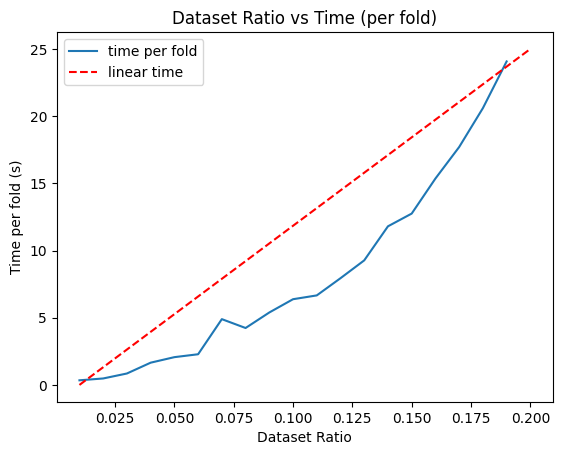

In [355]:
plt.plot(dataset_ratios, np.array(times)/3, label='time per fold')
plt.plot([0.01,0.2], [0, 25], 'r--', label='linear time')
plt.title('Dataset Ratio vs Time (per fold)')
plt.xlabel('Dataset Ratio')
plt.ylabel('Time per fold (s)')
plt.legend()
plt.savefig('runtime_vs_dataset_ratio_perfold.png')

In [ ]:
def predict(features, b):
        # sign( x.w+b )
        dot_result = np.sign(np.dot(features.T,w)+b)
        return dot_result.astype(int).flatten()
    
l=[]
for xi in X:
    l.append(predict(w, b))
l=np.array(l).astype(int).flatten()
print(confusion_matrix(y,l))
# print(classification_report(y, l))

# Classification accuracy

In [1]:
# import pickle

# # load the model
# with open('final_model.pkl', 'rb') as f:
#     model = pickle.load(f)

%run Model_w_Conv.ipynb
%run Trainerw_Conv.ipynb

rsvm = Trainer_conv(data, no_features, r=0.1, v=10, delta=-0.8, beta=0.4)
results, convergence_info = rsvm.train()
results

In [10]:
convergence_info['model_0']

{'info': {'ws': [37.61974710240129, 0.0],
  'f': [439.3502433467812, 0.0],
  'df': [11842970.667947982]}}

Text(0.5, 1.0, 'Test Set Confusion Matrix (10-fold average)')

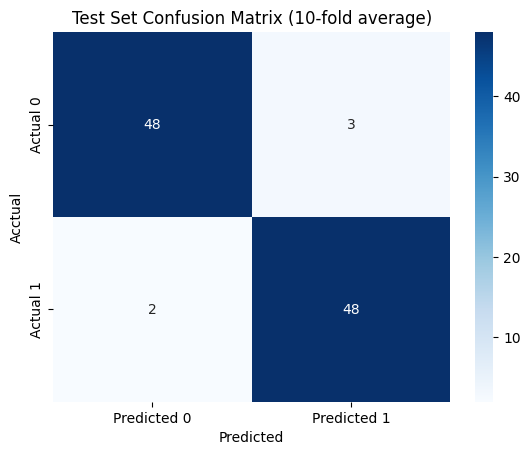

In [18]:
# plot the confusion matrix:
cm = np.ceil(np.mean(results['confusion_matrix'], axis=0))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Acctual')
plt.title('Test Set Confusion Matrix (10-fold average)')
# plt.savefig('confusion_matrix.png', dpi=600)